## CS441: Applied ML - HW 1

Darian Irani - irani2 - CS441

### Parts 1-2: MNIST

Include all the code for generating MNIST results below

In [55]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats


def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid 
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

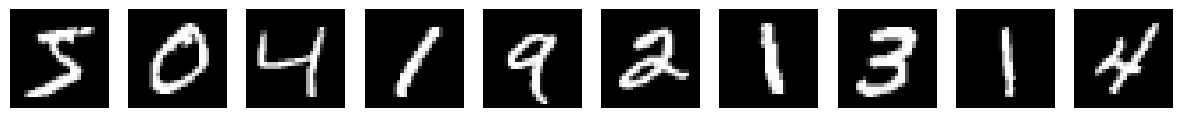

Total size: train=60000, test =10000


In [56]:
# example of using MNIST load, display, indices, and count functions
(x_train, y_train), (x_test, y_test) = load_mnist()
display_mnist(x_train[:10],1,10)
print('Total size: train={}, test ={}'.format(len(x_train), len(x_test)))

1. Retrieval, Clustering, and NN Classification

In [57]:
# Retrieval

def get_nearest(x_q, X):
    dist_min = np.inf
    idx_min = -1

    for n in range(len(X)):
        dist = np.sum((X[n] - x_q) ** 2)
        if dist < dist_min:
            dist_min = dist
            idx_min = n

    return idx_min


j = get_nearest(x_test[0], x_train)
print(j)
j = get_nearest(x_test[1], x_train)
print(j)


53843
28882


Displaying cluster centers after iteration 1


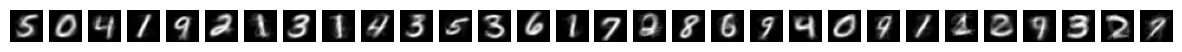

Displaying cluster centers after iteration 10


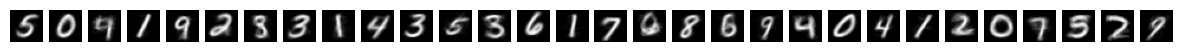

In [58]:
def kmeans(X, K, niter=10):
    centers = X[:K].copy()
    assignments = np.zeros(len(X), dtype=int)

    for iteration in range(niter):
        # Reset assignments at the start of each iteration
        assignments.fill(0)

        # Assign each data point to the nearest center
        for i in range(len(X)):
            assignments[i] = get_nearest(X[i], centers)

        # Update the centers
        for k in range(K):
            if np.any(assignments == k):
                centers[k] = np.mean(X[assignments == k], axis=0)
            else:
                # If no points are assigned to a cluster, skip updating that center
                continue

        # Display the cluster centers after the 1st and 10th iterations for K=30
        if K == 30 and (iteration == 0 or iteration == niter - 1):
            print(f"Displaying cluster centers after iteration {iteration + 1}")
            display_mnist(centers, 1, K)  # Assuming K can be accommodated in a single row

    return centers, assignments

# Load and display MNIST data
(x_train, y_train), (x_test, y_test) = load_mnist()

# Running kmeans with K=30 and displaying centers after 1st and 10th iterations
K = 30
centers, idx = kmeans(x_train[:1000], K)



In [59]:
# 1-NN

# TO DO

def k_nn(x_test, x_train, y_train):
    
    predictions = []
    
    for x in x_test:
        min_index = get_nearest(x, x_train)
        predictions.append(y_train[min_index])
    return predictions


def error(predictions, y_test):
    error_rate = (sum(pred != true for pred, true in zip(predictions, y_test))) / len(y_test)
    return error_rate

predictions_1k = k_nn(x_test[:100], x_train[:1000], y_train[:1000])
error_rate_1k = error(predictions_1k, y_test[:100])
print(f"Error rate using 1000 training samples: {error_rate_1k}")

predictions_10k = k_nn(x_test[:100], x_train[:10000], y_train[:10000])
error_rate_10k = error(predictions_1k, y_test[:100])
print(f"Error rate using 10000 training samples: {error_rate_10k }")



Error rate using 1000 training samples: 0.17
Error rate using 10000 training samples: 0.17


2. Make it fast

In [62]:
# install libraries you need for part 2

import faiss
import time

In [63]:
# retrieval

# TO DO (check that you're using FAISS correctly)

# exact search
index = faiss.IndexFlatL2(x_train.shape[1]) 
index.add(x_train)
dist, idx = index.search(x_test[:2],1)

print("FAISS indices:", idx.flatten())
print("get_nearest indices:", [get_nearest(x_test[i], x_train) for i in range(2)])


FAISS indices: [53843 28882]
get_nearest indices: [53843, 28882]


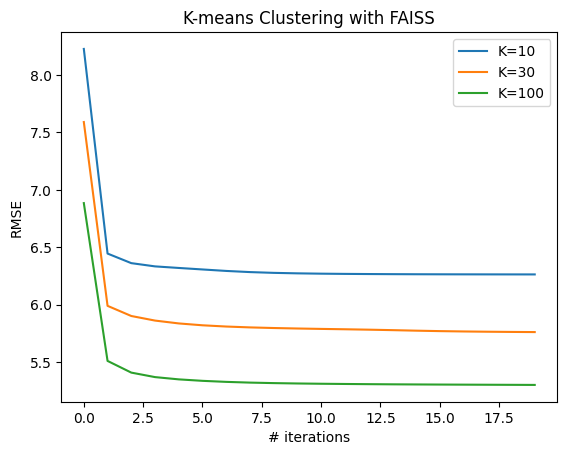

In [64]:
def kmeans_fast(X, K, niter=20):
  
    centers = X[:K].copy()
    # Convert centers to float32
    centers = centers.astype(np.float32)

    rmse_list = []

    for iteration in range(niter):
        # Create a new index for FAISS
        index = faiss.IndexFlatL2(X.shape[1])
        index.add(centers)

        # Find the nearest center for all samples
        dists, idx = index.search(X, 1)  
        
        # Compute RMSE
        rmse = np.sqrt(np.mean(dists))
        # rmse = np.sqrt(np.mean((x_train - centers[idx])**2))
        rmse_list.append(rmse)

        # Update cluster centers
        new_centers = np.zeros_like(centers)
        for k in range(K):
            # Select points that belong to cluster k
            points_in_cluster = X[idx.reshape(-1) == k]
            if len(points_in_cluster) > 0:
                new_centers[k] = np.mean(points_in_cluster, axis=0)
            else:
                # If no points are assigned to the cluster, use the old center
                new_centers[k] = centers[k]

        # Check for convergence (if centers didn't change, break)
        if np.allclose(centers, new_centers):
            break

        centers = new_centers

    return centers, rmse_list

for K in [10, 30, 100]:
    centers, rmse = kmeans_fast(x_train.astype(np.float32), K, niter=20)
    plt.plot(np.arange(len(rmse)), rmse, label=f'K={K}')

plt.legend(), plt.ylabel('RMSE'), plt.xlabel('# iterations')
plt.title('K-means Clustering with FAISS')
plt.show()




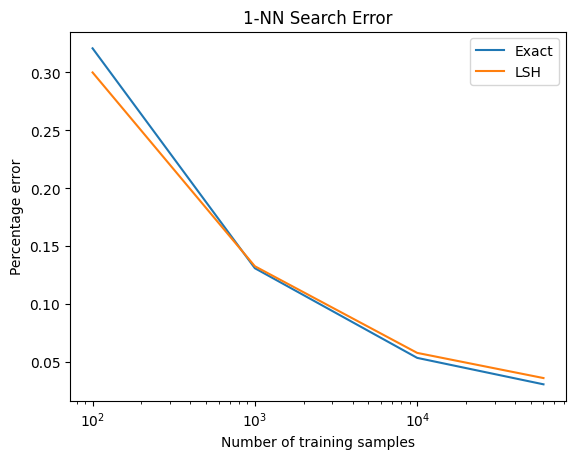

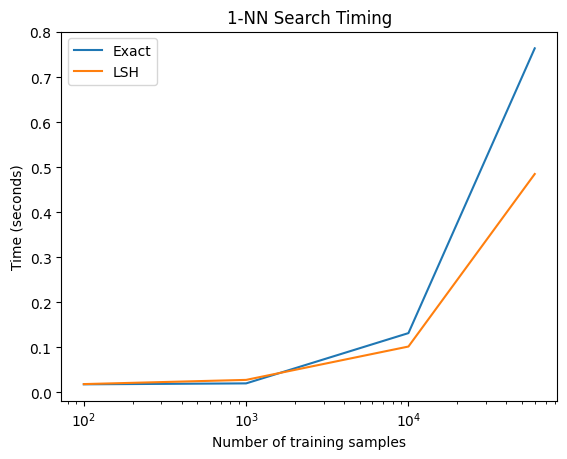

In [65]:
# # 1-NN

nsample = [100, 1000, 10000, 60000]
acc_exact = []
acc_lsh = []
timing_exact = []
timing_lsh = []

for s in nsample:
    # Exact search
    index_exact = faiss.IndexFlatL2(x_train[:s].shape[1])
    index_exact.add(x_train[:s].astype(np.float32))
    
    start_time = time.time()
    _, idx_exact = index_exact.search(x_test.astype(np.float32), 1)
    timing_exact.append(time.time() - start_time)

    # Calculate accuracy for exact search
    acc_exact.append(np.mean(y_train[idx_exact.reshape(-1)] == y_test))

    # LSH approximate search
    dim = x_train[:s].shape[1]
    index_lsh = faiss.IndexLSH(dim, dim)
    index_lsh.train(x_train[:s].astype(np.float32))
    index_lsh.add(x_train[:s].astype(np.float32))
    
    start_time = time.time()
    _, idx_lsh = index_lsh.search(x_test.astype(np.float32), 1)
    timing_lsh.append(time.time() - start_time)

    # Calculate accuracy for LSH search
    acc_lsh.append(np.mean(y_train[idx_lsh.reshape(-1)] == y_test))


error_exact = [1 - acc for acc in acc_exact]
error_lsh = [1 - acc for acc in acc_lsh]

plt.semilogx(nsample, error_exact, label='Exact')
plt.semilogx(nsample, error_lsh, label='LSH')
plt.legend(), plt.ylabel('Percentage error'), plt.xlabel('Number of training samples')
plt.title('1-NN Search Error')
plt.show()

plt.semilogx(nsample, timing_exact, label='Exact')
plt.semilogx(nsample, timing_lsh, label='LSH')
plt.legend(), plt.ylabel('Time (seconds)'), plt.xlabel('Number of training samples')
plt.title('1-NN Search Timing')
plt.show()



In [66]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

# TO DO

x_train_faiss = x_train.astype(np.float32)
x_test_faiss = x_test.astype(np.float32)
index = faiss.IndexFlatL2(x_train_faiss.shape[1])
index.add(x_train_faiss)

# Perform the search on the full test set for the 1 nearest neighbor.
_, indices = index.search(x_test_faiss, 1)

# Retrieve the predicted labels using the indices returned by the search.
predicted_labels = y_train[indices.flatten()]

confuse = confusion_matrix(y_test, predicted_labels)

# Find out which label is most often confused with '2'.
confuse[2][np.argsort(confuse[2])[-2]] 

# Label '7' is misclassified 16 times




16

## Part 3: Temperature Regression

Include all your code used for part 2 in this section.  

In [46]:
import numpy as np
# from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  
  datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW1/Code/temperature_data.npz"
  T = np.load(datadir)
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target date
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()




Feature 361: city = Cleveland, day= -1
Baseline - prediction using previous day: RMSE=3.460601246750482


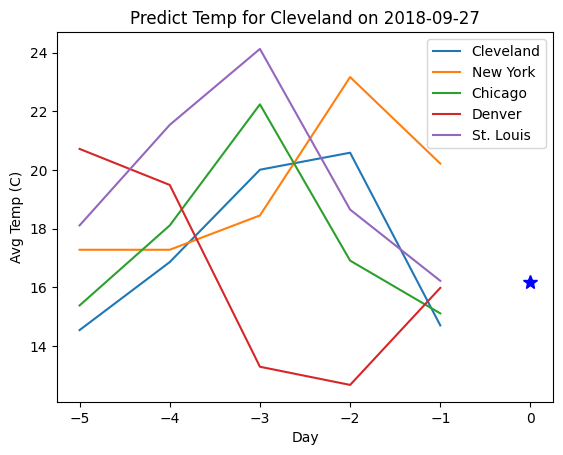

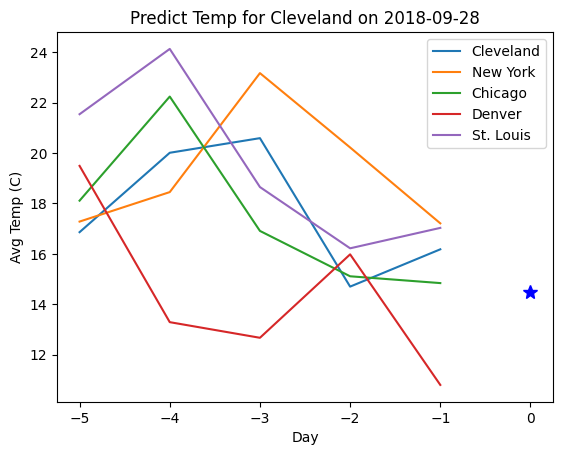

In [47]:
# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()
''' Data format:
      x_train, y_train: features and target value for each training sample (used to fit model)
      x_val, y_val: features and target value for each validation sample (used to select hyperparameters, such as regularization and K)
      x_test, y_test: features and target value for each test sample (used to evaluate final performance)
      dates_xxx: date of the target value for the corresponding sample
      feature_to_city: maps from a feature number to the city
      feature_to_day: maps from a feature number to a day relative to the target value, e.g. -2 means two days before
      Note: 361 is the temperature of Cleveland on the previous day
'''
f = 361
print('Feature {}: city = {}, day= {}'.format(f,feature_to_city[f], feature_to_day[f]))
baseline_rmse = np.sqrt(np.mean((y_val[1:]-y_val[:-1])**2)) # root mean squared error example
print('Baseline - prediction using previous day: RMSE={}'.format(baseline_rmse))

# plot first two x/y for val
plot_temps(x_val[0], y_val[0], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[0])
plot_temps(x_val[1], y_val[1], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[1])



In [48]:
# K-NN Regression

def get_distances(X_trn, x_tst):
    """
    Calculate L2 distances from a test point to all training points.
    """
    distances = np.sqrt(np.sum((X_trn - x_tst) ** 2, axis=1))
    return distances



def regress_KNN(X_trn, y_trn, X_tst, K=3):
  '''
  Predict the target value for each data point in X_tst using a
  K-nearest neighbor regressor based on (X_trn, y_trn), with L2 distance.
  Input: X_trn[i] is the ith training data. y_trn[i] is the ith training label. K is the number of closest neighbors to use.
  Output: return y_pred, where y_pred[i] is the predicted ith test value
  '''
  # TO DO
    
  y_pred = []
  
  for x_tst in X_tst:
      # Calculate distances from the test point to all training points using the revised function
      dists = get_distances(X_trn, x_tst)
      nearest_indices = np.argsort(dists)[:K]  # Get indices of K nearest neighbors
      # Predict by averaging the labels of K nearest neighbors
      y_pred.append(np.mean(y_trn[nearest_indices]))
      
  return np.array(y_pred)



def normalize_features(x, y, fnum):
  ''' Normalize the features in x and y.
      For each data sample i:
        x2[i] = x[i]-x[i,fnum]
        y2[i] = y[i]-x[i,fnum]
  '''
  # TO DO

  x2 = x - x[:, fnum][:, np.newaxis]
  y2 = y - x[:, fnum]
  return x2, y2


def calculate_rmse(y_pred, y_true):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


# KNN with original features

# TO DO

# Run K-NN regression
y_pred = regress_KNN(X_trn=x_train, y_trn=y_train, X_tst=x_test, K=5)

# Calculate and print RMSE for original features
rmse_original = calculate_rmse(y_test, y_pred)
print(f"RMSE for original features with K={5}: {rmse_original}")


# Normalize features
x_train_norm, y_train_norm = normalize_features(x_train, y_train, fnum=361)
x_val_norm, y_val_norm = normalize_features(x_val, y_val, fnum=361)

# KNN with normalized features
y_pred_normalized = regress_KNN(x_train_norm, y_train_norm, x_val_norm, K=3)
rmse_normalized = calculate_rmse(y_pred_normalized, y_val_norm)
print(f"RMSE for normalized features: {rmse_normalized}")




RMSE for original features with K=5: 3.249556245363484
RMSE for normalized features: 3.174005914679923


## Part 5: Stretch Goals
Include all your code used for part 5 in this section. You can copy-paste code from parts 1-3 if it is re-usable.

In [11]:
# Stretch: KNN MNIST

from keras.datasets import mnist
import numpy as np
import faiss

def load_mnist():
    '''
    Loads, reshapes, and normalizes the data
    '''
    (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
    x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 784-d vectors
    x_test = np.reshape(x_test, (len(x_test), 28*28))
    maxval = x_train.max()
    x_train = x_train / maxval  # normalize values to range from 0 to 1
    x_test = x_test / maxval
    return (x_train, y_train), (x_test, y_test)

# Assuming the load_mnist function correctly loads and preprocesses the data
(x_train, y_train), (x_test, y_test) = load_mnist()

# Splitting the training data into actual training and validation sets
# First 50000 for training, remaining for validation
# x_val = x_train[50000:]
# y_val = y_train[50000:]
# x_train = x_train[:50000]
# y_train = y_train[:50000]

# Full training, full test set
x_val = x_test
y_val = y_test
x_train = x_train
y_train = y_train

def KNN_MNIST_faiss(x_train, y_train, x_val, K=3):
    x_train_faiss = x_train.astype(np.float32)
    x_val_faiss = x_val.astype(np.float32)
    
    d = x_train_faiss.shape[1]
    
    index = faiss.IndexFlatL2(d)
    index.add(x_train_faiss)
    
    D, I = index.search(x_val_faiss, K)  # D: Distances, I: Indices
    
    y_pred = []
    for i in range(len(x_val)):
        # Get labels of K nearest neighbors
        labels = y_train[I[i]]
        
        # Count occurrences of each label
        label_counts = np.bincount(labels, minlength=10)
        
        # Find the most common label(s)
        max_count = np.max(label_counts)
        common_labels = np.where(label_counts == max_count)[0]
        
        if len(common_labels) > 1:
            # Tie: choose the label of the closest sample among the tied labels
            for idx in I[i]: 
                if y_train[idx] in common_labels:
                    y_pred.append(y_train[idx])
                    break
        else:
            # No tie: choose the most common label
            y_pred.append(common_labels[0])
    
    return np.array(y_pred)

def error_MNIST(y_pred, y_val):
    error_rate = np.mean(y_pred != y_val)
    return error_rate


K_values = [1, 3, 5, 11, 25]
for K in K_values:
    y_pred = KNN_MNIST_faiss(x_train, y_train, x_val, K=K)
    error_rate = error_MNIST(y_pred, y_val)
    print(f"Error rate for K={K}: {error_rate*100}%")


Error rate for K=1: 3.09%
Error rate for K=3: 2.83%
Error rate for K=5: 3.0700000000000003%
Error rate for K=11: 3.27%
Error rate for K=25: 3.9%


In [19]:
# Stretch: KNN regression (Select K)

import numpy as np

def load_temp_data():
  
  datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW1/Code/temperature_data.npz"
  T = np.load(datadir)
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# Load temperature data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()

def get_distances(X_trn, x_tst):
    """
    Calculate L2 distances from a test point to all training points.
    """
    distances = np.sqrt(np.sum((X_trn - x_tst) ** 2, axis=1))
    return distances

def regress_KNN(X_trn, y_trn, X_tst, K=3):
  '''
  Predict the target value for each data point in X_tst using a
  K-nearest neighbor regressor based on (X_trn, y_trn), with L2 distance.
  Input: X_trn[i] is the ith training data. y_trn[i] is the ith training label. K is the number of closest neighbors to use.
  Output: return y_pred, where y_pred[i] is the predicted ith test value
  '''
  # TO DO
    
  y_pred = []
  
  for x_tst in X_tst:
      # Calculate distances from the test point to all training points using the revised function
      dists = get_distances(X_trn, x_tst)
      nearest_indices = np.argsort(dists)[:K]  # Get indices of K nearest neighbors
      # Predict by averaging the labels of K nearest neighbors
      y_pred.append(np.mean(y_trn[nearest_indices]))
      
  return np.array(y_pred)

# Define the normalization function
def normalize_features(x, y, fnum):
    x2 = x - x[:, fnum][:, np.newaxis]
    y2 = y - x[:, fnum]
    return x2, y2

# Define RMSE calculation function
def calculate_rmse(y_pred, y_true):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# # KNN with original features
# K_values = [1, 3, 5, 11, 25]
# print("Original Features:")
# for K in K_values:
#     y_pred = regress_KNN(X_trn=x_train, y_trn=y_train, X_tst=x_val, K=K)  # Use x_val for validation
#     rmse_original = calculate_rmse(y_pred, y_val)  # Use y_val for validation
#     print(f"RMSE for K={K}: {rmse_original}")

# # Normalize features for the training and validation set
# fnum = 361  # Assuming this is the correct feature number for previous day's temperature in Cleveland
# x_train_norm, y_train_norm = normalize_features(x_train, y_train, fnum)
# x_val_norm, y_val_norm = normalize_features(x_val, y_val, fnum)

# # KNN with normalized features
# print("\nNormalized Features:")
# for K in K_values:
#     y_pred_normalized = regress_KNN(x_train_norm, y_train_norm, x_val_norm, K=K)
#     rmse_normalized = calculate_rmse(y_pred_normalized, y_val_norm)
#     print(f"RMSE for normalized features with K={K}: {rmse_normalized}")



# For K = 11 and normalized:

# Normalize features for the training and validation set
fnum = 361  # Assuming this is the correct feature number for previous day's temperature in Cleveland
x_train_norm, y_train_norm = normalize_features(x_train, y_train, fnum)
x_test_norm, y_test_norm = normalize_features(x_test, y_test, fnum)

# KNN with normalized features
print("\nNormalized Features:")

y_pred_normalized = regress_KNN(x_train_norm, y_train_norm, x_test_norm, K=11)
rmse_normalized = calculate_rmse(y_pred_normalized, y_test_norm)
print(f"RMSE for normalized features with K={11}: {rmse_normalized}")



Normalized Features:
RMSE for normalized features with K=11: 2.7671311757775685


In [39]:
import faiss
import numpy as np


def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()




def run_faiss_kmeans(X, K, niter, nredo, seed=123):
    d = X.shape[1]
    kmeans = faiss.Kmeans(d, K, niter=niter, nredo=nredo, seed=seed)
    kmeans.train(X)
    # After training, compute the sum of squared distances from each point to its cluster center
    D, _ = kmeans.index.search(X, 1)
    # Compute RMSE
    rmse = np.sqrt(np.mean(D))
    return rmse

# Assuming x_train is loaded and preprocessed correctly
x_train_faiss = x_train.astype(np.float32)

# Configuration sets
configs = [
    {"niter": 10, "nredo": 5},
    {"niter": 50, "nredo": 1},
    {"niter": 4, "nredo": 5},
    {"niter": 20, "nredo": 1}
]

# Run experiments
K = 30
results = {config: [] for config in range(len(configs))}

for i, config in enumerate(configs):
    print(f"Running configuration: {config}")
    for seed in range(5):  # Repeat test five times with different seeds
        rmse = run_faiss_kmeans(x_train_faiss, K, config["niter"], config["nredo"], seed=seed)
        results[i].append(rmse)
        print(f"Run {seed + 1}, RMSE: {rmse}")

# Calculate and print mean and standard deviation of RMSE for each configuration
for i, config in enumerate(configs):
    mean_rmse = np.mean(results[i])
    std_rmse = np.std(results[i])
    print(f"Configuration {config}, Mean RMSE: {mean_rmse}, Std RMSE: {std_rmse}")


Running configuration: {'niter': 10, 'nredo': 5}
Run 1, RMSE: 5.791625022888184
Run 2, RMSE: 5.789511203765869
Run 3, RMSE: 5.789932727813721
Run 4, RMSE: 5.785751819610596
Run 5, RMSE: 5.781244277954102
Running configuration: {'niter': 50, 'nredo': 1}
Run 1, RMSE: 5.78638219833374
Run 2, RMSE: 5.77720832824707
Run 3, RMSE: 5.7691240310668945
Run 4, RMSE: 5.776084899902344
Run 5, RMSE: 5.776626110076904
Running configuration: {'niter': 4, 'nredo': 5}
Run 1, RMSE: 5.8296637535095215
Run 2, RMSE: 5.835312366485596
Run 3, RMSE: 5.819028854370117
Run 4, RMSE: 5.829253196716309
Run 5, RMSE: 5.800961494445801
Running configuration: {'niter': 20, 'nredo': 1}
Run 1, RMSE: 5.789977550506592
Run 2, RMSE: 5.7789764404296875
Run 3, RMSE: 5.7753987312316895
Run 4, RMSE: 5.792483806610107
Run 5, RMSE: 5.794531345367432
Configuration {'niter': 10, 'nredo': 5}, Mean RMSE: 5.7876129150390625, Std RMSE: 0.0037176674231886864
Configuration {'niter': 50, 'nredo': 1}, Mean RMSE: 5.777085304260254, Std RMSE

In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24SP/hw1" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_SP24_HW1_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")